In [20]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# import seaborn as sns

# Analysis
import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
# import intake

# Import Ngl with pyn_env active 
# import Ngl

# import metpy.calc as mpc
# from metpy.units import units
# from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Try to open files

In [3]:
gustDir = '/glade/scratch/mdfowler/archive/F2010climo.f09_f09_mg17.TestGustGlobal.001/atm/hist/'
ctrlDir = '/glade/scratch/mdfowler/archive/F2010climo.f09_f09_mg17.TestGustGlobal_Control.001/atm/hist/'

yrs = np.asarray(['0002','0003','0004','0005'])

# Get list of all h0 file names 
fileList_gust = []
fileList_ctrl = []
for iYrs in range(len(yrs)):
    for fileGust in glob.glob(gustDir+"*.h0."+yrs[iYrs]+"-??.nc"):
        fileList_gust = np.append(fileList_gust,fileGust)
    for fileCtrl in glob.glob(ctrlDir+"*.h0."+yrs[iYrs]+"-??.nc"):
        fileList_ctrl = np.append(fileList_ctrl,fileCtrl)
        
fileList_gust = np.sort(fileList_gust)
fileList_ctrl = np.sort(fileList_ctrl)


In [10]:
## Figure out how to read those into a single xarray? 
gustDS = xr.open_mfdataset(fileList_gust, combine='nested', concat_dim="time")
print('Done opening gust files')

ctrlDS = xr.open_mfdataset(fileList_ctrl, combine='nested', concat_dim="time")
print('Done opening ctrl files') 



Done opening ctrl files


In [15]:
## Subtract 15 days from the monthly files so that they're in roughly the middle of the actual month they're averaged over 
gustDS['time'] = gustDS.time.values - timedelta(days = 15) 
ctrlDS['time'] = ctrlDS.time.values - timedelta(days = 15) 


In [8]:
np.shape(gustDS.LHFLX.values)

(48, 192, 288)

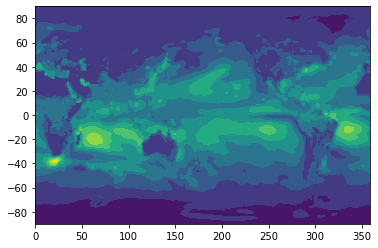

In [9]:
plt.contourf(gustDS.lon.values, gustDS.lat.values, gustDS.LHFLX.values[8,:,:])

## Take a look at some differences 

In [30]:
'''
Inputs:  meanStyle: mean over seasons or over all days 
         varSel:    variable name to get mean of 
         levSel:    Use zero for a 2D variable; otherwise, select 3D level with this 
'''

def plot_contourf(meanStyle, varSel, levSel, DSctrl_in, DStest_in):

    ## Plot 2D variables 
    if ( (levSel==0) & (len(np.shape(DSctrl_in[varSel]))==3) ):
        DSctrl = DSctrl_in 
        DStest = DStest_in
        
        levString = ''
    
    ## Plot 3D variables
    elif len(np.shape(DSctrl_in[varSel]))==4:
        DSctrl = DSctrl_in.isel(ilev=levSel) 
        DStest = DStest_in.isel(ilev=levSel)
        
        levString = ' ilev='+str(levSel)
    
    
    ## One row of plots for each season 
    if meanStyle=='seasonal': 
        ## Set up figure
        fig,axs = plt.subplots(4,3, figsize=(18,15),
                              subplot_kw={'projection':ccrs.PlateCarree()})
        axs     = axs.ravel()  
        fig.subplots_adjust(hspace=0.45, wspace=0.2)
        
        meanCtrl = DSctrl[varSel].groupby('time.season').mean(dim='time')
        meanTest = DStest[varSel].groupby('time.season').mean(dim='time')
        
        iPlot = 0 
        for iSeason in range(4):
            ## Plot raw values
            cMax  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 90), np.nanpercentile(meanTest[iSeason,:,:], 90)])
            cMin  = np.nanmax([np.nanpercentile(meanCtrl[iSeason,:,:], 10), np.nanpercentile(meanTest[iSeason,:,:], 10)])
            cStep = (cMax - cMin)/100.0
            
            contour_plot = axs[0+iPlot].contourf(DSctrl.lon.values, DSctrl.lat.values,
                                           meanCtrl[iSeason,:,:],
                                           np.arange(cMin, cMax+cStep, cStep), extend='both')

            contour_plot = axs[1+iPlot].contourf(DStest.lon.values, DStest.lat.values, 
                                           meanTest[iSeason,:,:],
                                           np.arange(cMin, cMax+cStep, cStep),extend='both')
        
             # Add colorbar
            ax_position = axs[1+iPlot].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.02, ax_position.width+0.1, 0.01])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
            if hasattr(DSctrl[varSel], 'units'):
                cbar.set_label(DSctrl[varSel].units,fontsize=11)

             ## Plot difference 
            diffVar = meanTest[iSeason,:,:] - meanCtrl[iSeason,:,:]
            
            cMax      = np.nanpercentile(diffVar, 98) 
            cMin      = np.nanpercentile(diffVar, 2)
            evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
            cStep     = (evenPoint*2)/100.0
            contour_plot = axs[2+iPlot].contourf(DStest.lon.values, DStest.lat.values, 
                            diffVar, 
                            np.arange(-evenPoint, evenPoint+cStep, cStep), 
                            cmap='bwr',extend='both')
            # Add colorbar
            ax_position = axs[2+iPlot].get_position()
            cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.02, ax_position.width+0.04, 0.01])
            if varSel=='Q':
                cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
            else:
                cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
            if hasattr(DSctrl[varSel], 'units'):
                cbar.set_label(DSctrl[varSel].units,fontsize=11)

            axs[0+iPlot].coastlines()
            axs[1+iPlot].coastlines()
            axs[2+iPlot].coastlines()

            if iSeason==0:
                axs[0+iPlot].set_title(varSel+' '+meanCtrl.season.values[iSeason]+'\nCtrl '+levString)
                axs[1+iPlot].set_title('Test')
                axs[2+iPlot].set_title('Test-Ctrl')
            else: 
                axs[0+iPlot].set_title(meanCtrl.season.values[iSeason])

                
            iPlot = iPlot+3
        
    ## Look at annual mean
    elif meanStyle=='all':
        ## Set up figure
        fig,axs = plt.subplots(1,3, figsize=(18,5),
                              subplot_kw={'projection':ccrs.PlateCarree()})
        axs     = axs.ravel()  
        fig.subplots_adjust(wspace=0.2)
        
        ## Plot raw values (and weight by number of days in month: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/)
        month_length = gustDS.time.dt.days_in_month
        wgts         = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
        
        varCtrl = DSctrl[varSel]
        varTest = DStest[varSel]
        
        condCtrl = varCtrl.isnull()
        condTest = varTest.isnull()
        onesCtrl = xr.where(condCtrl, 0.0, 1.0)
        onesTest = xr.where(condTest, 0.0, 1.0)
        
        ctrl_sum     = (varCtrl * wgts).sum(dim="time")
        test_sum     = (varTest * wgts).sum(dim="time")
        onesCtrl_sum = (onesCtrl * wgts).sum(dim="time")
        onesTest_sum = (onesTest * wgts).sum(dim="time")
        
        meanCtrl = ctrl_sum / onesCtrl_sum
        meanTest = onesTest_sum / onesTest_sum
        
        cMax  = np.nanmax([np.nanpercentile(meanCtrl, 98), np.nanpercentile(meanTest, 98)])
        cMin  = np.nanmax([np.nanpercentile(meanCtrl, 2), np.nanpercentile(meanTest, 2)])
        cStep = (cMax - cMin)/100.0
    
        contour_plot = axs[0].contourf(DSctrl.lon.values, DSctrl.lat.values,
                        meanCtrl,
                        np.arange(cMin, cMax+cStep, cStep), extend='both')

        contour_plot = axs[1].contourf(DStest.lon.values, DStest.lat.values, 
                        meanTest,
                        np.arange(cMin, cMax+cStep, cStep),extend='both')
        
         # Add colorbar
        ax_position = axs[1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.09, ax_position.width+0.1, 0.03])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if hasattr(DSctrl[varSel], 'units'):
            cbar.set_label(DSctrl[varSel].units,fontsize=11)

        ## Plot difference 
        diffVar = meanTest - meanCtrl
        cMax    = np.nanpercentile(diffVar, 98) 
        cMin    = np.nanpercentile(diffVar, 2)
        evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
        cStep      = (evenPoint*2)/100.0
        contour_plot = axs[2].contourf(DStest.lon.values, DStest.lat.values, 
                        diffVar, 
                        np.arange(-evenPoint, evenPoint+cStep, cStep), 
                        cmap='bwr',extend='both')
        # Add colorbar
        ax_position = axs[2].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.09, ax_position.width, 0.03])
        if varSel=='Q':
            cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.1e')
        else:
            cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.2f')
        if hasattr(DSctrl[varSel], 'units'):
            cbar.set_label(DSctrl[varSel].units,fontsize=11)
        
        axs[0].coastlines()
        axs[1].coastlines()
        axs[2].coastlines()
        
        axs[0].set_title(varSel+'\nCtrl '+levString)
        axs[1].set_title('Test')
        axs[2].set_title('Test-Ctrl') 
    
    return

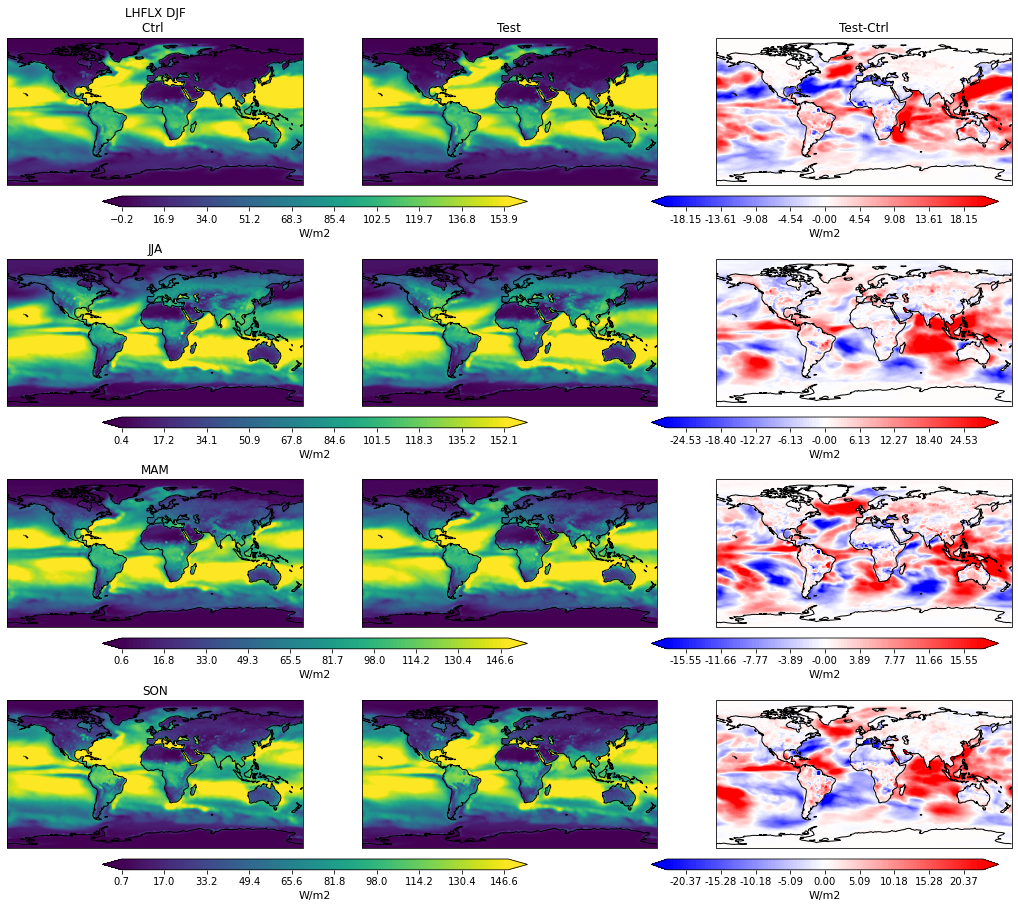

In [31]:
plot_contourf('seasonal', 'LHFLX', 0, ctrlDS, gustDS)


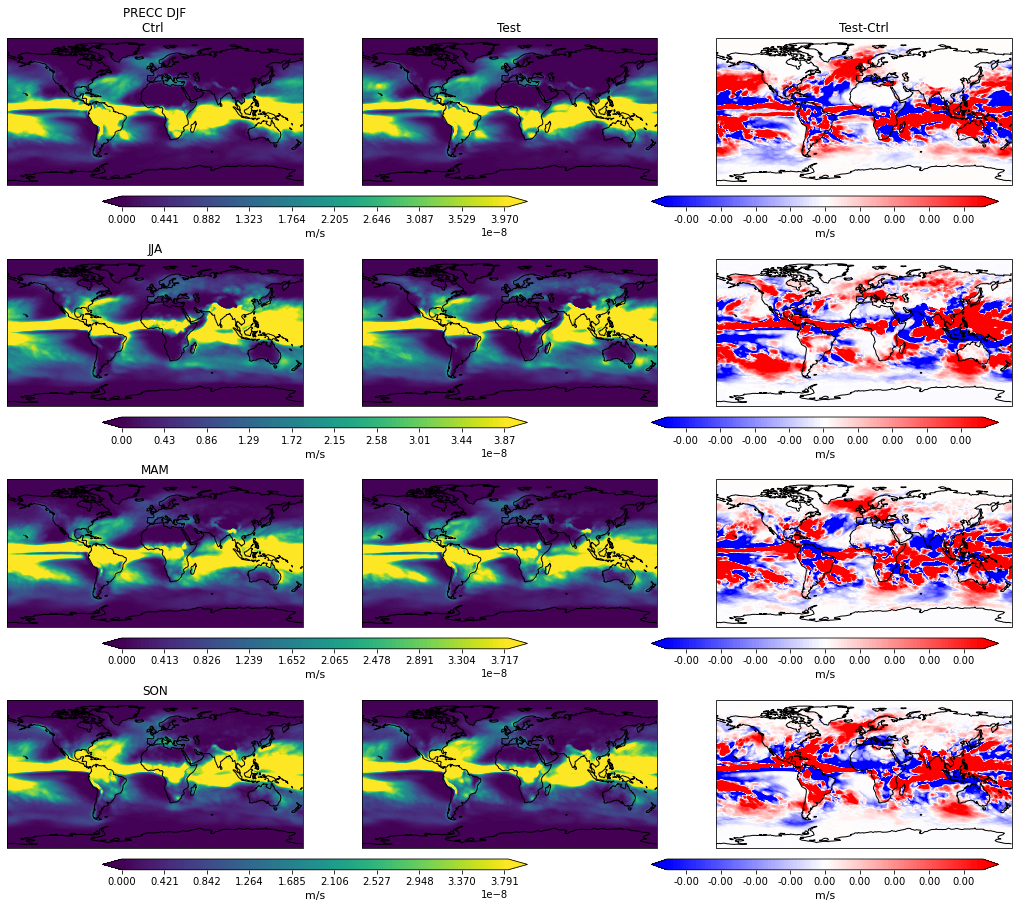

In [24]:
plot_contourf('seasonal', 'PRECC', 0, ctrlDS, gustDS)


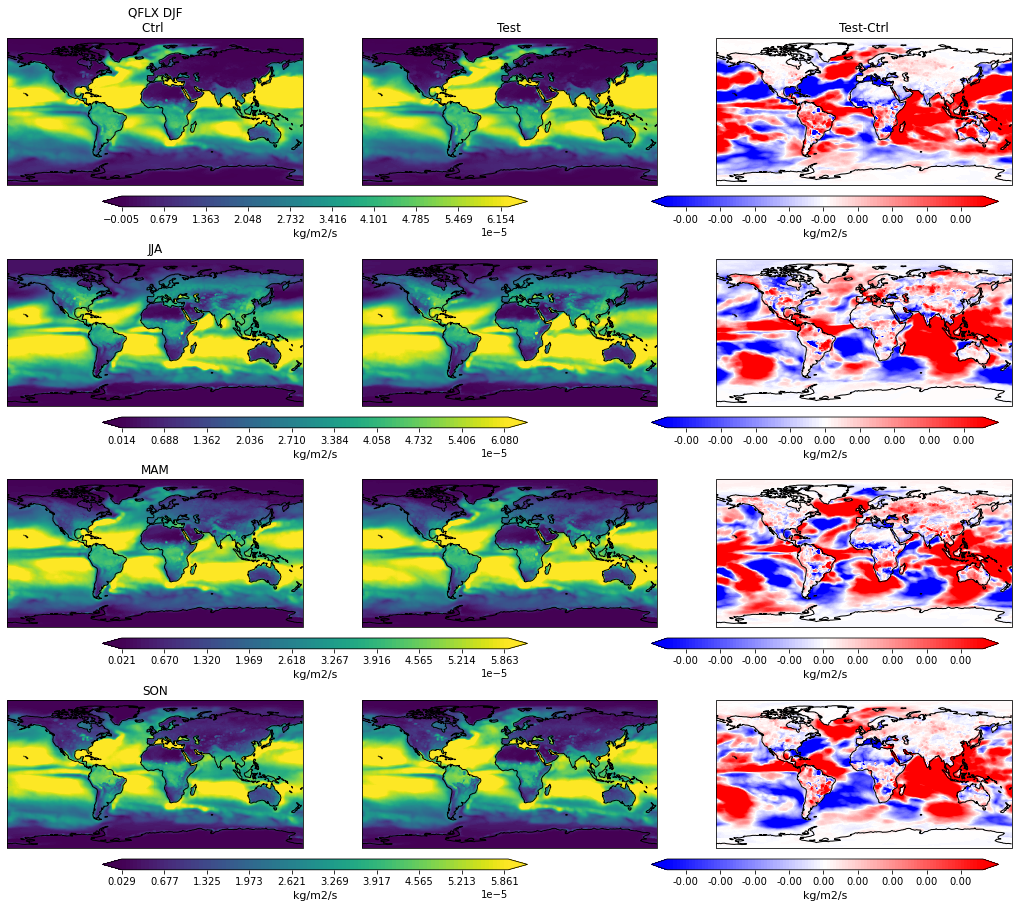

In [25]:
plot_contourf('seasonal', 'QFLX', 0, ctrlDS, gustDS)
